## Patterns

### Class Complexity


We've seen that using object orientation can produce quite complex class structures, with classes owning each other, instantiating each other,
and inheriting from each other.

There are lots of different ways to design things, and decisions to make.

> - How much flexibility should I allow in this class's inner workings?
> - Should I split this related functionality into multiple classes or keep it in one?
> - To reuse functionality: should I use inheritance, or add class variable which it is delegated to?

#### Inheritance vs composition

The last point is known as `is-a` vs `has-a` or inheritance vs composition.

Both options allow us to define a way for classes to collaborate while also having a single responsibility.
As a rule of thumb, we suggest choosing composition over inheritance unless you have a strong reason.
As we go into below, composition introduces fewer dependencies and assumptions about how your code will be used in the future.

**Inheritance** *(is-a)*:

- Used if you want to have the same functionality across multiple instances
- Abstracting commonly used methods or data, so all children can use the generic functionality
    - This has a drawback because we make large assumptions about how the code will be used in the future,
      which is often hard or impossible to do the first time
- If we find a bug in the functionality, this can be fixed in one place
    - This is good because one change can be cascaded
    - This can be bad because every subclass relies on its parent and changing one may need us to change the other
      (known as tight coupling)


**Composition** *(has-a)*:

- Create separate classes (component) which carry out the shared functionality.
- Instead of inheriting a method, instantiate the class with the components as class variables,
  when that functionality is required then we call that method on from the component.
- Unlike inheritance, you can design each component's interface independently
  so that it knows how to interact with other parts of your code
- Potential to have some code duplication
    - Doesn't have the problem of side effects cascading when you alter one component.

We've linked to an article which carries out a deep dive on this topic in the [other resources section](#Other-resources)

### Design Patterns


Programmers have noticed that there are certain ways of arranging classes that work better than others.

These are called "design patterns".

They were first collected on one of the [world's first Wikis](http://c2.com/cgi/wiki?WelcomeVisitors), 
as the [Portland Pattern Repository](http://c2.com/cgi-bin/wiki?PatternIndex).


### Reading a pattern


A description of a pattern in a book such as the [Gang Of Four](https://www.worldcat.org/title/design-patterns-elements-of-reusable-object-oriented-software/oclc/31171684)
book ([UCL Library](https://ucl-new-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=UCL_LMS_DS21146030410004761&context=L&vid=UCL_VU2&search_scope=CSCOP_UCL&tab=local&lang=en_US)) usually includes:

* **Intent** - what's the purpose
* **Motivation** - why you want to use it
* **Applicability** - when do you want to use it
* **Structure** - what does it look like (e.g., UML diagram)
* **Participants** - What are the different classes in it
* **Collaborations** - how they work together
* **Consequences** - What are the results and trade-offs
* **Implementation** - How is it implemented
* **Sample Code** - In practice.


### Introducing Some Patterns


There are lots and lots of design patterns, and it's a great literature to get into to
read about design questions in programming and learn from other people's experience.

We'll just show a few in this session:

* [Strategy](#Strategy-Pattern)
* [Factory Method](#Factory-Method)
* [Builder](#Builder-Pattern)

Some explanations won't click for some people even though we've tried.
So if you're stuck on wrapping your head around a pattern,
check out another explanation from the [other resources section](#Other-resources)

### Supporting code

In [1]:
%matplotlib inline
from unittest.mock import Mock

from IPython.display import SVG

def yuml(model):
    result=requests.get("http://yuml.me/diagram/boring/class/" + model)
    return SVG(result.content)


## Strategy Pattern


Define a family of algorithms, encapsulate each one
(e.g. use composition, or a `has-a` relationship instead of inheritance), and make them interchangeable.
Strategy lets the algorithm vary independently, without requiring any class that uses it to change.


### Strategy pattern example: sunspots

In [2]:
import csv
from datetime import datetime
import math

import matplotlib.pyplot as plt
from numpy import linspace, log, sqrt, array, delete
from numpy.fft import rfft,fft,fftfreq
from scipy.interpolate import UnivariateSpline
from scipy.signal import lombscargle
import requests

Consider the sequence of sunspot observations:

- We want to analyse the variation in sunspot activity
- Sunspot activity is cyclical, we expect to find this cycle to be about 11 years
- We can use the Fast Fourier Transform (FFT) to process the sunspot signal


In [3]:
def load_sunspots():
    with open("SIDC-SUNSPOTS_A.csv") as header:
        data = csv.reader(header)

        next(data) # Skip header row
        # The numbers we want are in the 2nd column
        return [float(row[1]) for row in data]

Text(0, 0.5, 'Sunspot number')

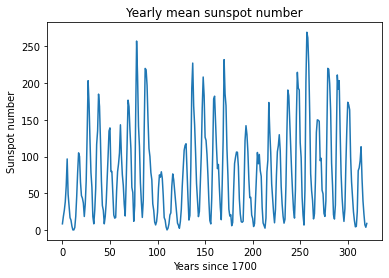

In [4]:
spots = load_sunspots()
plt.plot(spots)
plt.title("Yearly mean sunspot number")
plt.xlabel("Years since 1700")
plt.ylabel("Sunspot number")


### Sunspot cycle has periodicity

Text(0.5, 0, 'Real coefficients')

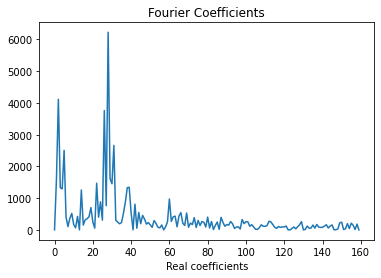

In [5]:
# Use Fast Fourier Transform
spectrum = rfft(spots)

# the first entry the sum of the data so let's remove it 
clean_spectrum = delete(spectrum, 0)

plt.figure()
plt.plot(abs(clean_spectrum.real))
plt.title("Fourier Coefficients")
plt.xlabel("Real coefficients")


### Years are not constant length

After we've started out analysis we realise there's a potential problem with this analysis:

* Years are not constant length
* Leap years exist
* But, the Fast Fourier Transform assumes evenly spaced intervals

We could:

* Ignore this problem, and assume the effect is small;
* Interpolate and resample to even times;
* Use a method which is robust to unevenly sampled series, such as [LSSA](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis);

We also want to find the period of the strongest periodic signal in the data, there are
various different methods we could use for this also, such as integrating the fourier series
by quadrature to find the mean frequency, or choosing the largest single value.

### Number of child-classes can increase quickly

We could implement a base class for our common code between the different approaches,
and define derived classes for each different algorithmic approach. However, this has drawbacks:

* The constructors for each derived class will need arguments for all the numerical method's control parameters,
such as the degree of spline for the interpolation method, the order of quadrature for integrators, and so on.
* Where we have multiple algorithmic choices to make (interpolator, periodogram, peak finder...) the number
of derived classes would explode: `class SunspotAnalyzerSplineFFTTrapeziumNearMode` is a bit unwieldy.
* The algorithmic choices are not then available for other projects (so we may have to reinvent the wheel next time)
* This design doesn't fit with a clean Ontology of "kinds of things": there's no Abstract Base for spectrogram generators...

### Apply the strategy pattern:

* We implement each algorithm for generating a spectrum as its own Strategy class.
* They all implement a common interface
* Arguments to strategy constructor specify parameters of algorithms, such as spline degree
* One strategy instance for each algorithm is passed to the constructor for the overall analysis

First, we'll define a helper class for our time series.

In [6]:
class Series:
    """Enhance NumPy N-d array with some helper functions for clarity"""
    def __init__(self, data):
        self.data = array(data)
        self.count = self.data.shape[0]
        self.start = self.data[0, 0]
        self.end = self.data[-1, 0]
        self.range = self.end - self.start
        self.step = self.range / self.count
        # create separate arrays as some algorithms require an array
        # as an argument and will throw an exception 
        # if a view of an array is passed as an argument
        self.times = self.data[:, 0].copy()
        self.values = self.data[:, 1].copy()
        self.plot_data = [self.times, self.values]
        self.inverse_plot_data = [1 / self.times[20:], self.values[20:]]

Then, our analysis class which contains all methods *except* the numerical methods

In [7]:
class SunspotDataAnalyser(object):
    def __init__(self, frequency_strategy):
        self.secs_per_year = (
                             datetime(2014, 1, 1) - datetime(2013, 1, 1)
                     ).total_seconds()
        self.load_data()
        self.frequency_strategy = frequency_strategy

    def format_date(self, date):
        date_format="%Y-%m-%d"
        return datetime.strptime(date, date_format)

    def date_to_years(self, date_string):
        return (self.format_date(date_string) - self.start_date
                ).total_seconds() / self.secs_per_year

    def load_data(self):
        start_date_str = '1700-12-31'
        self.start_date = self.format_date(start_date_str)


        with open("SIDC-SUNSPOTS_A.csv") as header:
            data = csv.reader(header)

            next(data) # Skip header row
            self.series = Series([[
                self.date_to_years(row[0]), float(row[1])]
                for row in data])

    def frequency_data(self):
        return self.frequency_strategy.transform(self.series)

Here is our existing simple fourier method, implemented as a strategy

In [8]:
class FourierNearestFrequencyStrategy:
    def transform(self, series):
        transformed = fft(series.values)[0:series.count//2]
        frequencies = fftfreq(series.count, series.step
                              )[0:series.count//2]
        return Series(list(
            zip(frequencies, abs(transformed)/series.count))
        )

A strategy based on interpolation to a spline

In [9]:
class FourierSplineFrequencyStrategy:
    def next_power_of_two(self, value):
        """Return the next power of 2 above value"""
        return 2**(1 + int(log(value) / log(2)))

    def transform(self, series):
        spline = UnivariateSpline(series.times, series.values)
        # Linspace will give us *evenly* spaced points in the series
        fft_count = self.next_power_of_two(series.count)
        points = linspace(series.start,series.end,fft_count)
        regular_xs = [spline(point) for point in points]
        transformed = fft(regular_xs)[0:fft_count//2]
        frequencies = fftfreq(fft_count,
                              series.range/fft_count)[0:fft_count//2]
        return Series(list(zip(frequencies, abs(transformed)/fft_count)))

A strategy using the Lomb-Scargle Periodogram

In [10]:
class LombFrequencyStrategy:
    def transform(self, series):
        frequencies = array(linspace(1.0 / series.range,
                                     0.5 / series.step,
                                     series.count))
        result = lombscargle(series.times,
                             series.values,
                             2.0 * math.pi * frequencies)
        return Series(list(
            zip(frequencies, sqrt(result / series.count)))
        )

Define our concrete solutions with particular strategies,
now it's more straightforward to interchange which numerical method we want the object to use.

In [11]:
fourier_model = SunspotDataAnalyser(FourierSplineFrequencyStrategy())
lomb_model = SunspotDataAnalyser(LombFrequencyStrategy())
nearest_model = SunspotDataAnalyser(FourierNearestFrequencyStrategy())

Use these new tools to compare solutions

In [12]:
comparison = fourier_model.frequency_data().inverse_plot_data + ['r']
comparison += lomb_model.frequency_data().inverse_plot_data + ['g']
comparison += nearest_model.frequency_data().inverse_plot_data + ['b']

Text(0, 0.5, 'Power')

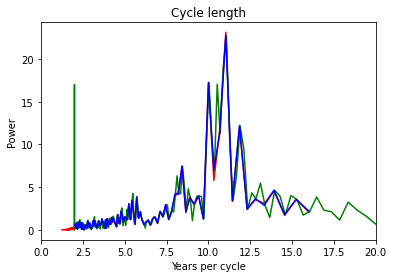

In [13]:
plt.plot(*comparison)
plt.xlim(0, 20)
plt.title("Cycle length")
plt.xlabel("Years per cycle")
plt.ylabel("Power")

Here we get the expected cycle length of around 11 years 🎉

## Factory Method


Here's what the Gang of Four Book says about Factory Method:

**Intent**:  Define an interface for creating an object, but let subclasses decide which class to instantiate.
Factory Method lets a class defer instantiation to subclasses.

**Applicability**: Use the Factory method pattern when:

* A class can't anticipate the class of objects it must create
* A class wants its subclasses to specify the objects it creates

### Factory UML


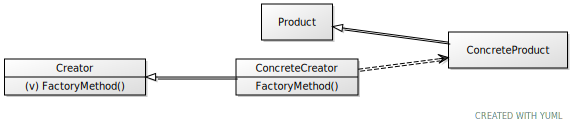

In [14]:
yuml("[Product]^-[ConcreteProduct], "
     "[Creator| (v) FactoryMethod()]^-[ConcreteCreator| FactoryMethod()], "
     "[ConcreteCreator]-.->[ConcreteProduct]")

This is all very abstract, so let's get a clearer idea of what that means with an example.

### Initial Example

We have created code that can analyse imaging data from different types of instrument.
However we still want to be able to interact with the imaging data in the same way,
independent of how each instrument stores its data.

To do this we have created a `GenericImage` class which implements default methods for interacting
with imaging data.



In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Create some mocked helper functions so example runs
ImageNormalize = Mock()
source_stretch = Mock()
Image = Mock()


class GenericImage:
    def __init__(self, data, header):
        """Read image and populate image metadata"""
        self.data = data
        ...

    def text_summary(self):
        """Outputs table summary table of image metadata"""
        return "\n".join(f"Instrument: {self.instrument}",
                         f"Observation Date: {self.observation_date}",
                         f"Scale: {self.scale}",
                         )

    def plot(self):
        """Plot normalised and coloured image"""
        normalised_data = self._pre_process()
        colour_data = self._get_colour_image(normalised_data)
        # plot the image data the image data
        colour_data.plot()
        plt.colorbar()
        plt.show()

    def _pre_process(self):
        """
        Default preprocessing for an image.
        This can be normalisation or conversion from raw data into a
        2d image
        """
        # image normaliser not shown here, but used as an example
        normaliser = ImageNormalize(stretch=source_stretch(0.01), clip=False)
        return normaliser.normalise(self.data)

    def _get_colour_image(self, normalised_data):
        """
        Converts image data into coloured image
        based on colourmap for the instrument
        """
        normalised_data.plot_settings['cmap'] = plt.get_cmap('inferno')
        normalised_data.plot_settings['norm'] = colors.Normalize(
            0, normalised_data.max())
        return normalised_data

### Implemented classes

Here are four example child classes that have implemented their own internal methods for normalising
the image data and creating a coloured image. We can use these in exactly the same way as our
GenericImage classes because of polymorphism, we're just using the same methods that exist in
the parent class.


In [16]:
# Imaging for astronomical data


class AIAImage(GenericImage):
    """Atmospheric Imaging Assembly image reader"""
    def __init__(self, data, header):
        super().__init__(data, header)
        self.instrument = "AIA"
        ...

    def _pre_process(self):
        # image normaliser not shown here, but used as an example
        normaliser = ImageNormalize(stretch=source_stretch(0.01),
                                    clip=False)
        return normaliser.normalise(self.data)

    def _get_colour_image(self, normalised_data):
        normalised_data.plot_settings['cmap'] = plt.get_cmap('Greys_r')
        normalised_data.plot_settings['norm'] = colors.LogNorm(
            100, normalised_data.max())
        return normalised_data


class HIImage(GenericImage):
        """STEREO-SECCHI Heliospheric Imager (HI) reader"""
        def __init__(self, data, header):
            super().__init__(data, header)
            self.instrument = "HI"
            ...

        def _pre_process(self):
            # image normaliser not shown here, but used as an example
            normaliser = ImageNormalize(stretch=source_stretch(0.25),
                                        clip=False)
            return normaliser.normalise(self.data)

        def _get_colour_image(self, normalised_data):
            normalised_data.plot_settings['cmap'] = (
                f'stereocor{self.detector[-1]!s}')
            normalised_data.plot_settings['norm'] = colors.Normalize(
                0, normalised_data.max())
            return normalised_data


# Imaging from microscopes


class MRC2014Image(GenericImage):
    """MRC/CCR4 2014 format Transmission Electron Microscopy (LM)
     Image reader"""
    def __init__(self, data, header):
        super().__init__(data, header)
        self.instrument = self._determine_instrument(header)
        ...

    def _determine_instrument(self, header):
        ...

    def _convert_to_2d(self, data):
        ...

    def _pre_process(self):
        return  self._convert_to_2d(self.data)

    def _get_colour_image(self, normalised_data):
        normalised_data.plot_settings['cmap'] = plt.get_cmap('Greys_r')
        normalised_data.plot_settings['norm'] = colors.LogNorm(
            100, normalised_data.max())
        return normalised_data


class LeicaImage(GenericImage):
    """Leica Confocal Microscopy image reader"""
    def __init__(self, data, header):
        super().__init__(data, header)
        self.instrument = self._determine_instrument(header)
        ...

    def _determine_instrument(self, header):
        ...

    def _convert_to_2d(self, data):
        ...

    def _pre_process(self):
        return  self._convert_to_2d(self.data)

    def _get_colour_image(self, normalised_data):
        normalised_data.plot_settings['cmap'] = plt.get_cmap('Greys_r')
        normalised_data.plot_settings['norm'] = colors.Normalize(
            0, normalised_data.max())
        return normalised_data


Let's imagine that we've done the hard work and implemented another 10 different image sources each for
astronomy images and microscopy images.

Whenever we load an image we want to use the correct image class, falling back to the GenericImage
if we can't fine a match from our known entities.


A naive implementation of this would to have an `if else` block where we use the image metadata
to determine what the right image class is.

In [17]:
class ImageFactory:
    """Base class that defines the factory interface"""
    
    def read_image(self, path):
        """Reads image from path, using the appropriate image class"""
        raise NotImplementedError(
            "Child classes must implement this method")


class AstronomyFactory(ImageFactory):
    def read_image(self, path):
        # reads in filepath and returns image data and metadata,
        data, header = Image.read(path)

        if str(header.get('detector', '')).startswith('HI'):
            return HIImage(data, header)
        elif str(header.get('instrume', '')).startswith('AIA'):
            return AIAImage(data, header)
        # ...this would continue for all 10 other image sources after
        # we've gone through all possible matches to known data types
        else:
            return GenericImage(data, header)
        
class MicroscopyFactory(ImageFactory):
    def read_image(self, path):
        # reads in filepath and returns image data and metadata,
        header = Image.get_header(path)

        if str(header.get('nversion', '')) == '20140':
            return MRC2014Image(Image.parse(path), header)
        elif path.suffix == '.lif':
            return LeicaImage(Image.parse(path), header)
        # ...this would continue for all 10 other image sources
        # after we've gone through all possible matches to known data types
        else:
            raise ValueError(
                f"File was not a recognised microscopy image: {path}")

Now users can use either factory to read in the right file types, using the same ImageFactory public interface. 

```python
astro_factory = AstronomyFactory()
micro_factory = MicroscopyFactory()

image_1 = astro_factory.read_image("testing/reading_AIA_AIA_193.jp2")
image_1.text_summary()
image_1.plot()

image_2 = micro_factory.read_image("testing/20110910_114721_s7h2A.lif")
image_2.plot()
```

This is the *factory method* pattern:
a common design solution to the need to defer the construction of child-objects to a derived class.
With polymorphism we can use any image object returned form the `read_image` function without
knowing the underlying image source.

Having this in a class can allow for more complex logic to determine which child
class should be returned from the factory method, including leveraging the statefullness of the
class to help with the logic.


## Builder Pattern

**Intent**: Separate the steps for constructing a complex object from its final representation.

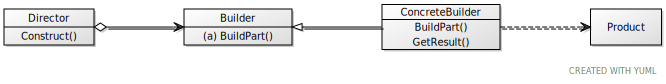

In [18]:
yuml("[Director|Construct()]<>->[Builder| (a) BuildPart()],"+
     " [Builder]^-[ConcreteBuilder| BuildPart();GetResult() ],"+
     "[ConcreteBuilder]-.->[Product]")

### Builder example

Imagine that we have a large model with many parameters that we want to run.

There's a lot more to defining a model than just adding agents of different kinds:
we need to define boundary conditions, specify wind speed or light conditions.

We could define all of this for an imagined advanced Model with a
very very long constructor, with lots of optional arguments:

In [19]:
class Model:
    def __init__(self, xsize, ysize,
                 agent_count, wind_speed,
                 agent_sight_range, eagle_start_location):
        pass

#### Builder preferred to complex constructor

However, long constructors easily become very complicated.
Instead, it can be cleaner to define a Builder for models.
A builder is like a deferred factory:
each step of the construction process is implemented as an individual method call,
and the completed object is returned when the model is ready.


In [20]:
# Create a bare bones Model so that we can use our builder

class Model:
    def __init__(self,):
        ...

    def simulate(self):
        print("Starting simulation")
        ...


In [21]:
class ModelBuilder:
    def start_model(self):
        self.model = Model()
        self.model.xlim = None
        self.model.ylim = None
        
    def set_bounds(self, xlim, ylim):
        self.model.xlim = xlim
        self.model.ylim = ylim
    
    def add_agent(self, xpos, ypos):
        pass # Implementation here
    
    def finish(self):
        self.validate()
        return self.model
    
    def validate(self):
        assert(self.model.xlim is not None)
        # Check that the all the
        # parameters that need to be set
        # have indeed been set.


Inheritance of an Abstract Builder for multiple concrete builders could be used
where there might be multiple ways to build models with the same set of calls to the builder:
for example a version of the model builder yielding models which can be executed
in parallel on a remote cluster.


### Using a builder

In [22]:
builder = ModelBuilder()
builder.start_model()

builder.set_bounds(500, 500)
builder.add_agent(40, 40)
builder.add_agent(400, 100)

model = builder.finish()
model.simulate()

Starting simulation


### Avoid staged construction without a builder.


We could, of course, just add all the building methods to the model itself,
rather than having the model be yielded from a separate builder.

This is an antipattern that is often seen: a class whose `__init__` constructor alone is insufficient
for it to be ready to use. A series of methods must be called, in the right order,
in order for it to be ready to use.

This results in very fragile code: its hard to keep track of whether an object instance is "ready" or not.
Use the builder pattern to keep deferred construction in control.

We might ask why we couldn't just use a validator in all of the methods that must follow the deferred constructors;
to check they have been called.
But we'd need to put these in *every* method of the class,
whereas with a builder, we can validate only in the `finish` method.


### Other resources

There are a lot of design patterns and one explanation might not work well for all people so here are some extra
sources of information about them. Spending some time to understand them can pay off in the future so you don't
reinvent the wheel!

- [Article on inheritance and composition in Python](https://realpython.com/inheritance-composition-python/)
- [Course on design patterns](https://www.linkedin.com/learning/python-design-patterns-2015/welcome)
  and [Advanced design patterns](https://www.linkedin.com/learning/python-advanced-design-patterns/welcome)
  with Python at [linkedin learning](https://www.ucl.ac.uk/isd/linkedin-learning).
- [A collection of design patterns and idioms in Python](https://github.com/faif/python-patterns).
- [Head First Design Patterns](http://www.worldcat.org/title/head-first-design-patterns/oclc/893944765)
  (Available [online at UCL](https://ucl-new-primo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=UCL_LMS_DS51233633660004761&context=L&vid=UCL_VU2&search_scope=CSCOP_UCL&tab=local&lang=en_US)
  or [O'Reilly](https://learning.oreilly.com/library/view/head-first-design/0596007124/?sso_link=yes&sso_link_from=university-college-london)
  : sign in using your UCL email) - based on Java (with [online course at linkedin learning](https://www.linkedin.com/learning/programming-foundations-design-patterns-2/don-t-reinvent-the-wheel)).
- [Design Pattern for Dummies](http://www.worldcat.org/title/design-patterns-for-dummies/oclc/69537420&referer=brief_results)
  (Available on [O'Reilly](https://learning.oreilly.com/library/view/design-patterns-for/9780471798545/?sso_link=yes&sso_link_from=university-college-london)
  : sign in using your UCL email).
